1. Process data into pickles with skip 40
2. Load this in to df dataloader
3. Train simple MLP map o -> a, observe it being okay
4. Get play subsequences, do goal conditioned BC, not just BC
5. LFP planner/encoder
6. Label a couple subsequences w/ language, and map that to the z space!

# Data Creation

In [1]:
# # # Clean old data
# import glob
# import os
# demo_dir = os.getcwd() + '/' + "kitchen_demos_multitask/"
# old = glob.glob(demo_dir + "/**/*.pkl", recursive=True)
# movies = glob.glob(demo_dir + "/**/*.mp4", recursive=True)
# for i in old + movies:
#     print(i)
#     os.remove(i)

/home/sholto/Desktop/AI/learning_from_play/kitchen_demos_multitask/postcorl_kettle_topknob_bottomknob_hinge/kitchen_playdata_2019_07_11_18_06_46_playback.mp4
/home/sholto/Desktop/AI/learning_from_play/kitchen_demos_multitask/friday_microwave_bottomknob_switch_slide/kitchen_playdata_2019_06_28_12_39_06_playback.mp4
/home/sholto/Desktop/AI/learning_from_play/kitchen_demos_multitask/friday_microwave_kettle_bottomknob_slide/kitchen_playdata_2019_06_28_12_02_31_playback.mp4


In [3]:
# data.build_dataset_from_mjl('', num_cpus=2)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Dataset

In [25]:
import glob
import data
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
import config
import random

dataset_path  = config.RPL_PATH
physical_devices = tf.config.list_physical_devices(config.DEVICE)
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
dataset, cnt = data.create_single_dataset(dataset_path)


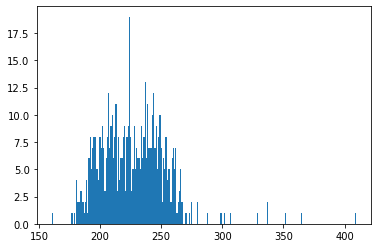

In [3]:
# Histogram of sequence lengths
plt.bar(cnt.keys(), cnt.values(), width=1)
plt.show()

In [13]:
train_partition = 0.8
N_TRAJS = len(dataset)
# SPlit into train and validation datasets
train_data = dataset[:int(N_TRAJS*train_partition)]
valid_data = dataset[int(N_TRAJS*train_partition):]

# Use the obs indices to get the full state of the env, both for us as obs, and for resetting.
START_OBS, END_OBS = 0,30
# Get just the dimensions of the goal for appending to the state
START_GOAL, END_GOAL = 9,30

MIN_SEQ_LEN = 40
MAX_SEQ_LEN = 80 # this is double LFP, but we need it at this length to get reasonable segments of behaviour.
OBS_DIM = 30
ACT_DIM = 9

In [113]:
class RobotSeqDataset():
    def __init__(self, dataset, batch_size=8, seq_len=40, prefetch_size=None, train_test_split=0.8, seed=42):
        self.N_TRAJS = len(dataset)

        # Split into train and validation datasets
        # List of trajectory dicts
        self._train_data = dataset[:int(self.N_TRAJS*train_test_split)] # raw data - private
        self._valid_data = dataset[int(self.N_TRAJS*train_test_split):]
        self.train_data = []
        self.valid_data = []

        # Use the obs indices to get the full state of the env, both for us as obs, and for resetting.
        self.START_OBS_IDX, self.END_OBS_IDX = 0,30
        # Get just the dimensions of the goal for appending to the state
        self.START_GOAL_IDX, self.END_GOAL_IDX = 9,30

        self.BATCH_SIZE = batch_size
        self.PREFETCH_SIZE = prefetch_size
        self.SEQ_LEN = seq_len
        self.OBS_DIM = 30
        self.ACT_DIM = 9

        self.random_obj = random.Random(seed)

    def create_goal(self, trajectory, ti, tf):
        return np.tile(trajectory['observations'][tf, self.START_GOAL_IDX:self.END_GOAL_IDX], (tf-ti,1))

    def traj_to_subtrajs(self, trajectory):
        """ Converts a T-length trajectory into M subtrajectories of length SEQ_LEN, pads time dim to SEQ_LEN """
        T = len(trajectory['observations'])
        subtrajs = []
        for ti in range(0,T,self.SEQ_LEN):
            tf = min(ti + self.SEQ_LEN, T-1) # Truncate subtrajs at the end of the trajectory
            pad_len = self.SEQ_LEN-(tf-ti)
            time_padding = ((0,pad_len),(0,0))
            subtraj_dict = {
                            'observations':np.pad(trajectory['observations'][ti:tf,self.START_OBS_IDX:self.END_OBS_IDX], time_padding)
                            , 'actions':np.pad(trajectory['actions'][ti:tf], time_padding)
                            , 'goals':np.pad(self.create_goal(trajectory, ti, tf), time_padding)
                            , 'init_qpos':None # Just use obs
                            , 'init_qvel':None # Todo: figure this out later - apparently velocities not used
                            }
            subtrajs.append(subtraj_dict)
        return subtrajs

    def convert_dataset(self):
        """ Converts raw dataset to a shuffled subtraj dataset """
        for train_sample in self._train_data:
            self.train_data.extend(self.traj_to_subtrajs(train_sample))

        for valid_sample in self._valid_data:
            self.valid_data.extend(self.traj_to_subtrajs(valid_sample))

    def create_tf_ds(self, ds_type='train'):
        dataset = self.train_data if ds_type=='train' else self.valid_data
        def gen():
            for d in dataset:
                yield (d['observations'], d['actions'], d['goals'])

        with tf.device('/cpu:0'):
            tf_ds =  tf.data.Dataset.from_generator(
                        gen
                        , output_types = (tf.float32, tf.float32, tf.float32)
                        , output_shapes = ((None,self.OBS_DIM), (None,self.ACT_DIM), (None,self.OBS_DIM-self.ACT_DIM))
                     )
            tf_ds = tf_ds.shuffle(len(dataset))
            tf_ds = tf_ds.batch(self.BATCH_SIZE, drop_remainder=True)
            tf_ds = tf_ds.prefetch(self.PREFETCH_SIZE)
        return tf_ds

In [114]:
rsd = RobotSeqDataset(dataset)

In [115]:
rsd.convert_dataset()

In [116]:
train_data, valid_data = rsd.create_tf_ds('train'), rsd.create_tf_ds('valid')

In [117]:
%%timeit
for batch in train_data:
    print([batch[0].shape, batch[1].shape, batch[2].shape])

[TensorShape([8, 40, 30]), TensorShape([8, 40, 9]), TensorShape([8, 40, 21])]
[TensorShape([8, 40, 30]), TensorShape([8, 40, 9]), TensorShape([8, 40, 21])]
[TensorShape([8, 40, 30]), TensorShape([8, 40, 9]), TensorShape([8, 40, 21])]
[TensorShape([8, 40, 30]), TensorShape([8, 40, 9]), TensorShape([8, 40, 21])]
[TensorShape([8, 40, 30]), TensorShape([8, 40, 9]), TensorShape([8, 40, 21])]
[TensorShape([8, 40, 30]), TensorShape([8, 40, 9]), TensorShape([8, 40, 21])]
[TensorShape([8, 40, 30]), TensorShape([8, 40, 9]), TensorShape([8, 40, 21])]
[TensorShape([8, 40, 30]), TensorShape([8, 40, 9]), TensorShape([8, 40, 21])]
[TensorShape([8, 40, 30]), TensorShape([8, 40, 9]), TensorShape([8, 40, 21])]
[TensorShape([8, 40, 30]), TensorShape([8, 40, 9]), TensorShape([8, 40, 21])]
[TensorShape([8, 40, 30]), TensorShape([8, 40, 9]), TensorShape([8, 40, 21])]
[TensorShape([8, 40, 30]), TensorShape([8, 40, 9]), TensorShape([8, 40, 21])]
[TensorShape([8, 40, 30]), TensorShape([8, 40, 9]), TensorShape(

In [241]:
# get obs, goal pairs where the goal is the end of the trajectory. This is quite a temporally extended and difficult task.
# this will be slow, bt its just for validification
def sample_MLP_GCBC_batch(data, batch_size = 64):
    obs, acts = data['obs'], data['acts']
    traj_idxs = np.random.choice(len(obs), batch_size)
    batch_obs = []
    batch_acts = [] 
    batch_goals = [] 
    for idx in traj_idxs:
        traj = obs[idx]
        tstep = np.random.choice(len(traj))
        batch_obs.append(obs[idx][tstep][START_OBS:END_OBS]), batch_acts.append(acts[idx][tstep])
        batch_goals.append(obs[idx][-1][START_GOAL:END_GOAL])
        
    batch_obs = np.concatenate([batch_obs, batch_goals], -1)
    return tf.convert_to_tensor(batch_obs, tf.float32), tf.convert_to_tensor(batch_acts, tf.float32), None

# sample seuqences between our min and max, where the goal is the end of sequence. 
def sample_sequence_batch(data, batch_size = 64):
    ''' THis function should give Batch_size, traj_len, dim for obs, goals, acts and mask'''
    obs, acts = data['obs'], data['acts']
    
    traj_idxs = np.random.choice(len(obs), batch_size)
    batch_obs = []
    batch_acts = [] 
    seq_lens = np.random.randint(MIN_SEQ_LEN, MAX_SEQ_LEN, batch_size)
    batch_goals = [] 
    batch_masks = []
    for i, idx in enumerate(traj_idxs):
        traj = obs[idx]
        subseq_len = seq_lens[i]
        max_start_idx = len(traj)-subseq_len
        start_idx = np.random.randint(0,max_start_idx)
        end_idx = start_idx + subseq_len
        mask_len = MAX_SEQ_LEN-subseq_len
        
        o = traj[start_idx:end_idx][:, START_OBS:END_OBS]
        o_mask = np.zeros([mask_len, OBS_DIM])
        
        o = np.concatenate([o, o_mask], 0)
        
        a = acts[idx][start_idx:end_idx]
        a_mask = np.zeros([mask_len, ACT_DIM])
        a = np.concatenate([a, a_mask], 0)
        batch_obs.append(o)
        batch_goals.append(obs[idx][end_idx][START_GOAL:END_GOAL])
        batch_acts.append(a)
        batch_masks.append(np.concatenate([np.ones(subseq_len), np.zeros(mask_len)]))
        
    
    batch_obs, batch_acts =  tf.convert_to_tensor(batch_obs, tf.float32), tf.convert_to_tensor(batch_acts, tf.float32)
    batch_goals =  tf.convert_to_tensor(np.tile(np.expand_dims(batch_goals, axis = 1), (1, MAX_SEQ_LEN, 1)), tf.float32)
    batch_masks =  tf.convert_to_tensor(batch_masks, tf.float32) # this will only be batch * seq_len, which is fine as this will be the same dimension as loss
    batch_obs = tf.concat([batch_obs, batch_goals], -1)
    return batch_obs, batch_acts, batch_masks

In [245]:
%%time
obs, acts, masks = sample_sequence_batch(train_data)
print(obs.shape, goals.shape, acts.shape, masks.shape)

(64, 80, 51) (64, 60, 21) (64, 80, 9) (64, 80)
CPU times: user 31.7 ms, sys: 0 ns, total: 31.7 ms
Wall time: 30.4 ms


In [246]:
%%time
# time trial
obs, acts, _ = sample_MLP_GCBC_batch(train_data)

CPU times: user 2.25 ms, sys: 0 ns, total: 2.25 ms
Wall time: 1.85 ms


# Model

In [247]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## Simple MLP Baseline
Use this to map obs -> act

In [248]:
# a basic determinsitc MLP
class deterministic_MLP(tf.keras.Model):

    def __init__(self, act_dim, layer_size = 256):
        super(deterministic_MLP, self).__init__()
        self.dense1 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(act_dim, activation=None)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.out(x)
    
    def act(self, inputs):
        return self.call(inputs)
    
# An MLP where the output is a mixture of 3 logistic distributions which we can sample from. 
class stochastic_MLP(tf.keras.Model):

    def __init__(self, act_dim, num_distribs = 3, layer_size = 256):
        super(stochastic_MLP, self).__init__()
        self.num_distribs = num_distribs
        self.act_dim = act_dim
        self.dense1 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.mu = tf.keras.layers.Dense(act_dim*num_distribs, activation=None)
        self.scale = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")
        self.weightings = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        mu, scale, weightings = self.mu(x), self.scale(x), self.weightings(x)
        mu, scale, weightings = tf.reshape(mu, (-1, self.act_dim, self.num_distribs)), tf.reshape(scale, (-1, self.act_dim, self.num_distribs)), tf.reshape(weightings, (-1, self.act_dim, self.num_distribs))
        dist = tfd.Logistic(loc=mu, scale=scale)
        
        mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                          probs=weightings),components_distribution=dist)
        
        return mixture
    
    def act(self, inputs):
        return self.call(inputs).sample()
    
    
class LSTM(tf.keras.Model):

    def __init__(self, act_dim, num_distribs = 3, layer_size = 512):
        super(LSTM, self).__init__()
        self.num_distribs = num_distribs
        self.act_dim = act_dim

        self.RNN1 = tf.keras.layers.LSTM(layer_size, return_sequences=True, return_state = True)
        self.RNN2 = tf.keras.layers.LSTM(layer_size, return_sequences=True, return_state = True)
        self.mu = tf.keras.layers.Dense(act_dim*num_distribs, activation=None)
        self.scale = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")
        self.weightings = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")

    def call(self, inputs, training=False, past_state = None):
        B = inputs.shape[0]
        state_out = None
        if len(inputs.shape) == 3:
            [x, _, _] = self.RNN1(inputs)
            [x, _, _] = self.RNN2(x)
        else:
            x = tf.expand_dims(inputs,1)
            [x, s1l1, s2l1] = self.RNN1(x, initial_state = past_state[0])
            [x, s1l2, s2l2] = self.RNN2(x, initial_state = past_state[1])
            state_out = [[s1l1, s2l1], [s1l2, s2l2]]
            

        mu, scale, weightings = self.mu(x), self.scale(x), self.weightings(x)
        mu, scale, weightings = tf.reshape(mu, (B, -1, self.act_dim, self.num_distribs)), tf.reshape(scale, (B, -1, self.act_dim, self.num_distribs)), tf.reshape(weightings, (B, -1, self.act_dim, self.num_distribs))
        dist = tfd.Logistic(loc=mu, scale=scale)
        
        mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                          probs=weightings),components_distribution=dist)
        if state_out is None:
            return mixture
        else:
            return mixture, state_out

# Training Loop

In [321]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar

import time

# Whether to use probabilstic MLP or not
PROBS = True
# Whether to use LSTM models, as probabilistic models are better they will all be PROB true
SEQ = True
# Action dimension
act_dim =  9

In [322]:

@tf.function
def step(obs,acts, model, mask=None):
    mu = model(obs)
    loss = tf.reduce_mean(tf.losses.MSE(mu, acts))
    return loss

@tf.function
def probabilistic_step(obs,acts, model, mask=None):
    
    mixture = model(obs)
    # make it the same dimension as the mask if we have one
    if mask is not None:
        loss = -tf.reduce_mean(tf.reduce_mean(mixture.log_prob(acts), -1) * mask)
    else:
        loss = -tf.reduce_mean(mixture.log_prob(acts), -1)
    return loss

@tf.function    
def train_step(obs,acts, model, optimizer, mask = None):
    with tf.GradientTape() as tape:
        loss = step(obs,acts, model, mask)
        
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss
        

In [323]:
# Instantiate an optimizer to train the model. Use same LR as LFP paper. 
optimizer = Adam(learning_rate=2e-4)
# Instantiate a loss function.

if PROBS:
    step = probabilistic_step
    if SEQ:
        get_batch = sample_sequence_batch
        model = LSTM(act_dim = act_dim)
    else:
        model = stochastic_MLP(act_dim = act_dim)
        get_batch = sample_MLP_GCBC_batch
else:
    model = deterministic_MLP(act_dim=act_dim)
    get_batch = sample_MLP_GCBC_batch

# Prepare the metrics.
# train_acc_metric = Accuracy()

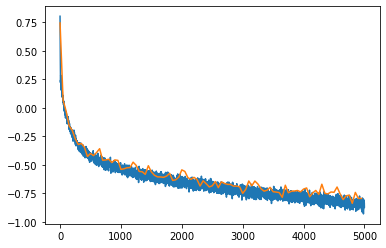

In [328]:
n_steps = 5000
t = 0
steps = []
losses = []
valid_losses = []
valid_steps = []


progbar = Progbar(n_steps, verbose=1, interval=0.5)
data_time = []
train_time = []
# TODO RAY async trajectories in background so we can watch it's learning progress. 
for t in range(0, n_steps):
    t1 = time.time()
    train_obs, train_acts, train_mask = get_batch(train_data)
    t2 = time.time()
    data_time.append(t2-t1) # Yo you got the ideal way to time profile this?
    loss = train_step(train_obs,train_acts, model, optimizer, train_mask)
    t3 = time.time()
    train_time.append(t3-t2)
    steps.append(t)
    losses.append(loss)
    if t % 50 == 0:
        valid_steps.append(steps)
        valid_obs, valid_acts, valid_mask = get_batch(valid_data)
        valid_loss = step(valid_obs, valid_acts, model, valid_mask)
        valid_losses.append(valid_loss)
        progbar.add(50, [('Loss', valid_loss)])
    
    
plt.plot(steps, losses)
plt.plot(valid_steps, valid_losses)

In [ ]:
print(sum(data_time), sum(train_time)) #Tristan pls fix my retarded data input pipieline

In [ ]:
model.summary()

In [ ]:
import gym
import adept_envs

env = gym.make("kitchen_relax-v1")

# MLP Evaluation

In [ ]:
# This below is only appropriate for non sequence models, which will aim for shorter timespans. 
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]

In [ ]:

o = env.reset()
# A few representative points along the trajectory for us to test how it goes from there (before it loses coherence
# over the long trajectory)
ZERO, QUARTER, HALF, THREEQ = 0, len(traj_obs)//4, len(traj_obs)//2, len(traj_obs)*3//4
# Get the init point
init_o = traj_obs[THREEQ][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
# select the goal as the end state of the trajectory 
goal = traj_obs[-1][START_GOAL:END_GOAL]
for i in range(len(traj_acts)):
    o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
    if PROBS:# need to sample from the model if its probabilistic. 
        a = model(o).sample()[0]
    else:
        a = model.predict(o)[0]
    #a = traj_acts[i]
    o, r, d, _ = env.step(a) # the key change
    
    env.render()

# LSTM Evaluation

In [ ]:

def test_subsequences():
    obs, acts, masks = sample_sequence_batch(valid_data)
    o = env.reset()
    idx = np.random.choice(len(obs))
    traj_end = len(np.where(masks[idx] == 1)[0])-1

    masks[idx][traj_end]
    start_pos = obs[idx][0][START_OBS:END_OBS].numpy()
    goal = obs[idx][traj_end][START_GOAL:END_GOAL]
    zero_vel = np.zeros(29)

    env.robot.reset(env, start_pos, zero_vel)
    o = np.squeeze(obs[idx][0])
    env.render()


    past_state = [None, None]

    for i in range(0, traj_end+1):
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()
    

In [ ]:
for i in range(0,100):
    test_subsequences()

In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


In [ ]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL]
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()

In [ ]:
goal

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])
#     print()
        
    # Display metrics at the end of each epoch.
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
#     for x_batch_val, y_batch_val in val_dataset:
#         test_step(x_batch_val, y_batch_val)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc),))    

In [253]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])
#     print()
        
    # Display metrics at the end of each epoch.
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
#     for x_batch_val, y_batch_val in val_dataset:
#         test_step(x_batch_val, y_batch_val)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc),))    

88.02201747894287 19.151499032974243


In [254]:
model.summary()

Model: "lstm_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               multiple                  1155072   
_________________________________________________________________
lstm_23 (LSTM)               multiple                  2099200   
_________________________________________________________________
dense_21 (Dense)             multiple                  13851     
_________________________________________________________________
dense_22 (Dense)             multiple                  13851     
_________________________________________________________________
dense_23 (Dense)             multiple                  13851     
Total params: 3,295,825
Trainable params: 3,295,825
Non-trainable params: 0
_________________________________________________________________


In [64]:
import gym
import adept_envs

env = gym.make("kitchen_relax-v1")

Reading configurations for Franka
Initializing Franka sim
registering the liscence


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# MLP Evaluation

In [271]:
# This below is only appropriate for non sequence models, which will aim for shorter timespans. 
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]

In [272]:

o = env.reset()
# A few representative points along the trajectory for us to test how it goes from there (before it loses coherence
# over the long trajectory)
ZERO, QUARTER, HALF, THREEQ = 0, len(traj_obs)//4, len(traj_obs)//2, len(traj_obs)*3//4
# Get the init point
init_o = traj_obs[THREEQ][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
# select the goal as the end state of the trajectory 
goal = traj_obs[-1][START_GOAL:END_GOAL]
for i in range(len(traj_acts)):
    o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
    if PROBS:# need to sample from the model if its probabilistic. 
        a = model(o).sample()[0]
    else:
        a = model.predict(o)[0]
    #a = traj_acts[i]
    o, r, d, _ = env.step(a) # the key change
    
    env.render()

# LSTM Evaluation

In [329]:

def test_subsequences():
    obs, acts, masks = sample_sequence_batch(valid_data)
    o = env.reset()
    idx = np.random.choice(len(obs))
    traj_end = len(np.where(masks[idx] == 1)[0])-1

    masks[idx][traj_end]
    start_pos = obs[idx][0][START_OBS:END_OBS].numpy()
    goal = obs[idx][traj_end][START_GOAL:END_GOAL]
    zero_vel = np.zeros(29)

    env.robot.reset(env, start_pos, zero_vel)
    o = np.squeeze(obs[idx][0])
    env.render()


    past_state = [None, None]

    for i in range(0, traj_end+1):
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()
    

In [ ]:
for i in range(0,100):
    test_subsequences()

In [353]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


In [354]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL]
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()

In [285]:
goal

array([ 1.26637224e-04, -3.02954932e-04, -6.29944632e-06,  2.72272731e-06,
        4.62284669e-05, -4.81784472e-05,  5.64736323e-05,  1.63806061e-05,
       -6.99730864e-01, -4.96205707e-02, -1.97302880e-04,  9.61040826e-03,
        7.20619393e-03,  4.98431317e-04, -2.09994927e-01,  7.28410795e-01,
        1.61963881e+00,  9.98537683e-01,  2.24488211e-03, -3.32025671e-03,
        5.11605555e-02])

2

In [239]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [74]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])
#     print()
        
    # Display metrics at the end of each epoch.
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
#     for x_batch_val, y_batch_val in val_dataset:
#         test_step(x_batch_val, y_batch_val)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc),))    


Epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



  1/565 [..............................] - ETA: 2:46 - Loss: 0.2236WARNING:tensorflow:5 out of the last 5 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


  7/565 [..............................] - ETA: 1:06 - Loss: 0.2273WARNING:tensorflow:8 out of the last 8 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 12/565 [..............................] - ETA: 1:01 - Loss: 0.2245WARNING:tensorflow:11 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 19/565 [>.............................] - ETA: 55s - Loss: 0.2090 WARNING:tensorflow:9 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 28/565 [>.............................] - ETA: 48s - Loss: 0.1998WARNING:tensorflow:8 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 34/565 [>.............................] - ETA: 47s - Loss: 0.1960WARNING:tensorflow:9 out of the last 12 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 41/565 [=>............................] - ETA: 45s - Loss: 0.1879WARNING:tensorflow:9 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 50/565 [=>............................] - ETA: 42s - Loss: 0.1790WARNING:tensorflow:7 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 58/565 [==>...........................] - ETA: 40s - Loss: 0.1715WARNING:tensorflow:9 out of the last 14 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 66/565 [==>...........................] - ETA: 39s - Loss: 0.1668WARNING:tensorflow:9 out of the last 13 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 77/565 [===>..........................] - ETA: 36s - Loss: 0.1622WARNING:tensorflow:6 out of the last 12 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 87/565 [===>..........................] - ETA: 34s - Loss: 0.1583WARNING:tensorflow:7 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 94/565 [===>..........................] - ETA: 34s - Loss: 0.1555WARNING:tensorflow:9 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


131/565 [=====>........................] - ETA: 24s - Loss: 0.1471WARNING:tensorflow:5 out of the last 16 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


161/565 [=======>......................] - ETA: 20s - Loss: 0.1430WARNING:tensorflow:5 out of the last 16 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


183/565 [========>.....................] - ETA: 17s - Loss: 0.1403WARNING:tensorflow:5 out of the last 12 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


565/565 [==============================] - 10s 19ms/step - Loss: 0.1199

Epoch 1
565/565 [==============================] - 0s 615us/step - Loss: 0.0969

Epoch 2
565/565 [==============================] - 0s 635us/step - Loss: 0.0876

Epoch 3
565/565 [==============================] - 0s 604us/step - Loss: 0.0812

Epoch 4
565/565 [==============================] - 0s 616us/step - Loss: 0.0763

Epoch 5
565/565 [==============================] - 0s 634us/step - Loss: 0.0722

Epoch 6
565/565 [==============================] - 0s 620us/step - Loss: 0.0688

Epoch 7
565/565 [==============================] - 0s 615us/step - Loss: 0.0659

Epoch 8
565/565 [==============================] - 0s 646us/step - Loss: 0.0631

Epoch 9
565/565 [==============================] - 0s 676us/step - Loss: 0.0607

Epoch 10
565/565 [==============================] - 0s 641us/step - Loss: 0.0586

Epoch 11
565/565 [==============================] - 0s 603us/step - Loss: 0.0568

Epoch 12
565/565 [================